## 3. Modélisation

### 3.1 Données texte :

#### 3.1.5 Modélisation texte - Réseaux convolutionnels 1D 

In [1]:
from keras.utils import np_utils 
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import re
import string
from joblib import load


In [2]:
import matplotlib.pyplot as plt

data=pd.read_csv('X_train_update.csv',index_col=0)
target=pd.read_csv('Y_train_CVw08PX.csv',index_col=0)
df=data.join(target)


## Nettoyage des données



Nous allons d'abord commencer à supprimer les mots vides, les caractères spéciaux et la ponctuation

In [3]:
df.description.fillna('',inplace=True)
df['text']=df.designation+df.description
df.drop(['designation','description'],axis=1,inplace=True)
df.head()

,productid,imageid,prdtypecode,text
0,3804725264,1263597046,10,Olivia: Personalisiertes Notizbuch / 150 Seite...
1,436067568,1008141237,2280,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...
2,201115110,938777978,50,Grand Stylet Ergonomique Bleu Gamepad Nintendo...
3,50418756,457047496,1280,Peluche Donald - Europe - Disneyland 2000 (Mar...
4,278535884,1077757786,2705,La Guerre Des TuquesLuc a des id&eacute;es de ...


In [ ]:
import re 
import string
def clean_text_round1(text):
  text = text.lower()
  text = re.sub('\[.*?\]', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\w*\d\w*', '', text)
  return text

round1 = lambda x: clean_text_round1(x)

In [ ]:
df.text=df.text.apply(round1)


In [ ]:
# Apply a second round of cleaning
def clean_text_round2(text):
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

round2 = lambda x: clean_text_round2(x)

In [ ]:
df.text=df.text.apply(round2)


In [ ]:
def remove_punct(text):
    translator = str.maketrans("", "", string.punctuation)
    return text.translate(translator)

df["text"] = df.text.map(remove_punct)

In [ ]:
df.text

0        olivia personalisiertes notizbuch   seiten  pu...
1        journal des arts le n°  du   lart et son march...
2        grand stylet ergonomique bleu gamepad nintendo...
3        peluche donald  europe  disneyland  marionnett...
4        la guerre des tuquesluc a des ideacutees de gr...
                               ...                        
84911                                            the sims 
84912    kit piscine acier nevada déco pierre ø  x  com...
84913    journal officiel de la republique francaise n°...
84914    table basse bois de récupération massif base b...
84915    gomme de collection  gommes pinguin glace vert...
Name: text, Length: 84916, dtype: object

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Initialiser la variable des mots vides
stop_words = set(stopwords.words('french'))
stop_words_en = set(stopwords.words('english'))
stop_words.update(stop_words_en)
stop_words.update([",", ".",'la','les','de','un','une','x'])

def stop_words_filtering(mots) : 
    tokens = []
    for mot in mots:
        if mot not in stop_words:
            tokens.append(mot)
    return tokens

df["text"] = df.text.map(stop_words_filtering)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Vectorisation du texte

Nous allons d'abord commencer par vectoriser tous les mots du texte et compter le nombre de mots uniques

In [ ]:
from collections import Counter
# Fonction retournant le nombre de mot unique
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count
counter = counter_word(df.text)



In [ ]:
num_unique_words = len(counter)
num_unique_words

215472

Nous allons ensuite séparer les données en un jeu d'entrainement et un jeu de test

In [ ]:

from sklearn.model_selection import train_test_split
y=target
y=y.replace(sorted(y['prdtypecode'].unique()),np.arange(0,27))


X_train,X_test,y_train,y_test = train_test_split(df.text,y,test_size=0.2,random_state=42)


Nous vectorisons la variable target en 27 colonnes afin de la rendre exploitable pour le RNN

In [ ]:
y_train = np_utils.to_categorical(y_train) 
y_test = np_utils.to_categorical(y_test)


In [ ]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

Nous utilisons la fonction Tokenizer qui affecte un chiffre à chaque mot unique du Dataset. La méthode text-to-sequences nous permet ensuite de vectoriser chaque annonce en remplaçant les mots par le chiffre correspondant au mot

In [ ]:
# Tokenize
from tensorflow.keras.preprocessing.text import Tokenizer

# On transforme nos mots en vecteurs d'entier
tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(X_train)




In [ ]:
# On transforme nos phrases en séquences d'entier
train_sequences = tokenizer.texts_to_sequences(X_train)
val_sequences = tokenizer.texts_to_sequences(X_test)



In [ ]:
print(X_train[1])
print(train_sequences[1])

journal des arts le n°  du   lart et son marche salon dart asiatique a paris  jacques barrere  francois perrier  la reforme des ventes aux encheres publiques  le sna fete ses cent ans
[2150, 7, 54, 1, 743, 33, 552, 29, 45647, 5828, 54, 1, 498, 20, 3308, 231, 2019, 4456, 7, 2075, 5828, 17019, 1, 622, 75, 1731, 15, 1, 21919, 11, 645, 1, 3744, 376, 1, 2657, 10, 45648, 39, 54, 163, 1, 2569, 2, 662, 6, 83652, 8, 6735, 5, 2, 395, 33610, 12, 54, 83653, 12, 54, 83654, 83655, 3015, 2, 83656]


La fonction pad_sequence nous permet d'harmoniser la longueur de chaque séquence vectorisée. Nous fixons la taille maximale du vecteur à 300.

In [ ]:
# On importe de tensorFlow
from tensorflow.keras.preprocessing.sequence import pad_sequences
# On définit la longueur max de chaque séquence.
max_length = 1500
# On "pad" nos phrases
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")

val_padded = pad_sequences(val_sequences, maxlen=max_length, padding="post", truncating="post")

In [ ]:
print(X_train[1])
print(train_sequences[1])
print(train_padded[1])

journal des arts le n°  du   lart et son marche salon dart asiatique a paris  jacques barrere  francois perrier  la reforme des ventes aux encheres publiques  le sna fete ses cent ans
[2150, 7, 54, 1, 743, 33, 552, 29, 45647, 5828, 54, 1, 498, 20, 3308, 231, 2019, 4456, 7, 2075, 5828, 17019, 1, 622, 75, 1731, 15, 1, 21919, 11, 645, 1, 3744, 376, 1, 2657, 10, 45648, 39, 54, 163, 1, 2569, 2, 662, 6, 83652, 8, 6735, 5, 2, 395, 33610, 12, 54, 83653, 12, 54, 83654, 83655, 3015, 2, 83656]
[2150    7   54 ...    0    0    0]


## Création du réseau convolutionnel à une dimension

Nous allons créer un réseau convolutionnel de 5 couches comprenant :
Une couche d'embedding,
Une couche de Dropout,
Une couche de convolution à une dimension et 256 filtres,
Une couche de max-pooling,
Une couche de sortie avec fonction d'activation softmax.


In [ ]:
from tensorflow.keras import layers

model = keras.models.Sequential()
model.add(layers.Embedding(num_unique_words, 34, input_length=max_length))
model.add(SpatialDropout1D(0.2))
model.add(Conv1D(256, 2, activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(27, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1500, 34)          7326048   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 1500, 34)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1499, 256)         17664     
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 27)                6939      
Total params: 7,350,651
Trainable params: 7,350,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:


loss = keras.losses.categorical_crossentropy
optim = keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy"]

model.compile(loss=loss, optimizer=optim, metrics=metrics)



In [ ]:
r = model.fit(train_padded, y_train,batch_size=200, epochs=2, validation_data=(val_padded, y_test), verbose=2)

Epoch 1/2
340/340 - 44s - loss: 0.1542 - accuracy: 0.9576 - val_loss: 0.8189 - val_accuracy: 0.7935
Epoch 2/2
340/340 - 44s - loss: 0.1157 - accuracy: 0.9680 - val_loss: 0.8610 - val_accuracy: 0.7884


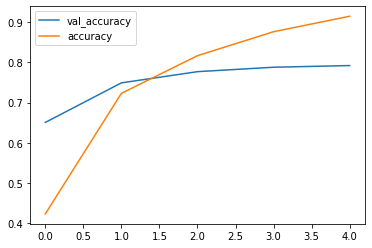

In [ ]:
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.plot(r.history['accuracy'], label= 'accuracy')
plt.legend()

Nous atteignons une val-accuracy de 79 %, comme pour les réseaux récurrents, ce modèle est confronté à de grosses problématiques d'overfitting malgré les couches de régularisation

In [ ]:
predictions = model.predict(val_padded)


In [ ]:
from sklearn.metrics import classification_report
y_pred=np.argmax(predictions,axis=1)
y_pred=pd.Series(y_pred)
y_pred=y_pred.replace(sorted(y_pred.unique()),sorted(target['prdtypecode'].unique()))
y_test=np.argmax(y_test,axis=1)
y_test=pd.Series(y_test)
y_test=y_test.replace(sorted(y_test.unique()),sorted(target['prdtypecode'].unique()))


In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          10       0.47      0.55      0.50       612
          40       0.59      0.65      0.62       521
          50       0.80      0.80      0.80       357
          60       0.94      0.85      0.89       161
        1140       0.73      0.78      0.75       539
        1160       0.90      0.92      0.91       786
        1180       0.70      0.57      0.63       146
        1280       0.64      0.59      0.61       961
        1281       0.67      0.44      0.53       424
        1300       0.83      0.89      0.86       974
        1301       0.91      0.86      0.88       169
        1302       0.77      0.72      0.75       507
        1320       0.80      0.76      0.78       672
        1560       0.86      0.79      0.82      1013
        1920       0.90      0.89      0.90       841
        1940       0.82      0.82      0.82       137
        2060       0.83      0.75      0.79      1029
        2220       0.84    

Nous atteignons un weighted f1_score de 79 % sur le jeu de test c'est la meilleure performance de tous les modèles qui ont été testés.